In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm
import math

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd

ModuleNotFoundError: No module named 'keras'

In [3]:
ctx = straxbra.XebraContext()

In [4]:
run = '00192'
peaks_data = ctx.get_array(run, 'peaks')

In [5]:
waveform = peaks_data['data']
integral = peaks_data['area']
width = peaks_data['width'][:,5]
timestamp = peaks_data['time']
risetime = -peaks_data['area_decile_from_midpoint'][:,1]

In [6]:
def CutCondition(waveform):
    
    maximum = max(waveform)
    FirstPeak_area = sum(waveform[:15]) # range in samples (not ns!)
    SecondPeak_area = sum(waveform[15:]) # range in samples (not ns!)

    
    if  FirstPeak_area > 100 and FirstPeak_area < 600 and SecondPeak_area > 40 and SecondPeak_area  < 200: 
#        print (i , secondS1_area, secondS1_peaktime)
        return(True)
    else:
        return(False)
    

In [7]:
def S2_found(waveform, integral, width):
    maximum_S2 = max(waveform)
    if integral > 500 and width >200 and width < 2000:
        return True
    else:
        return False

In [8]:
def Process(waveform, i):
    CutFlag = CutCondition(waveform[i])
    if CutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and S2_found(waveform = waveform[i+j],integral = integral[i+j], width = width[i+j]) == False: 
            j += 1
            counter_timestamp = timestamp[i+j]
        else:         
            if S2_found(waveform = waveform[i+j],integral = integral[i+j], width = width[i+j]):
                S2_area.append(integral[i+j])
                S1_area.append(integral[i])

                return
            else:
                return

In [9]:
num = len(waveform)

S1_area = []
S2_area = []

print_counter = 0.0
for i in range(0,num):
    
    Process(waveform,i)
    
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
        
print(1.0)

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0


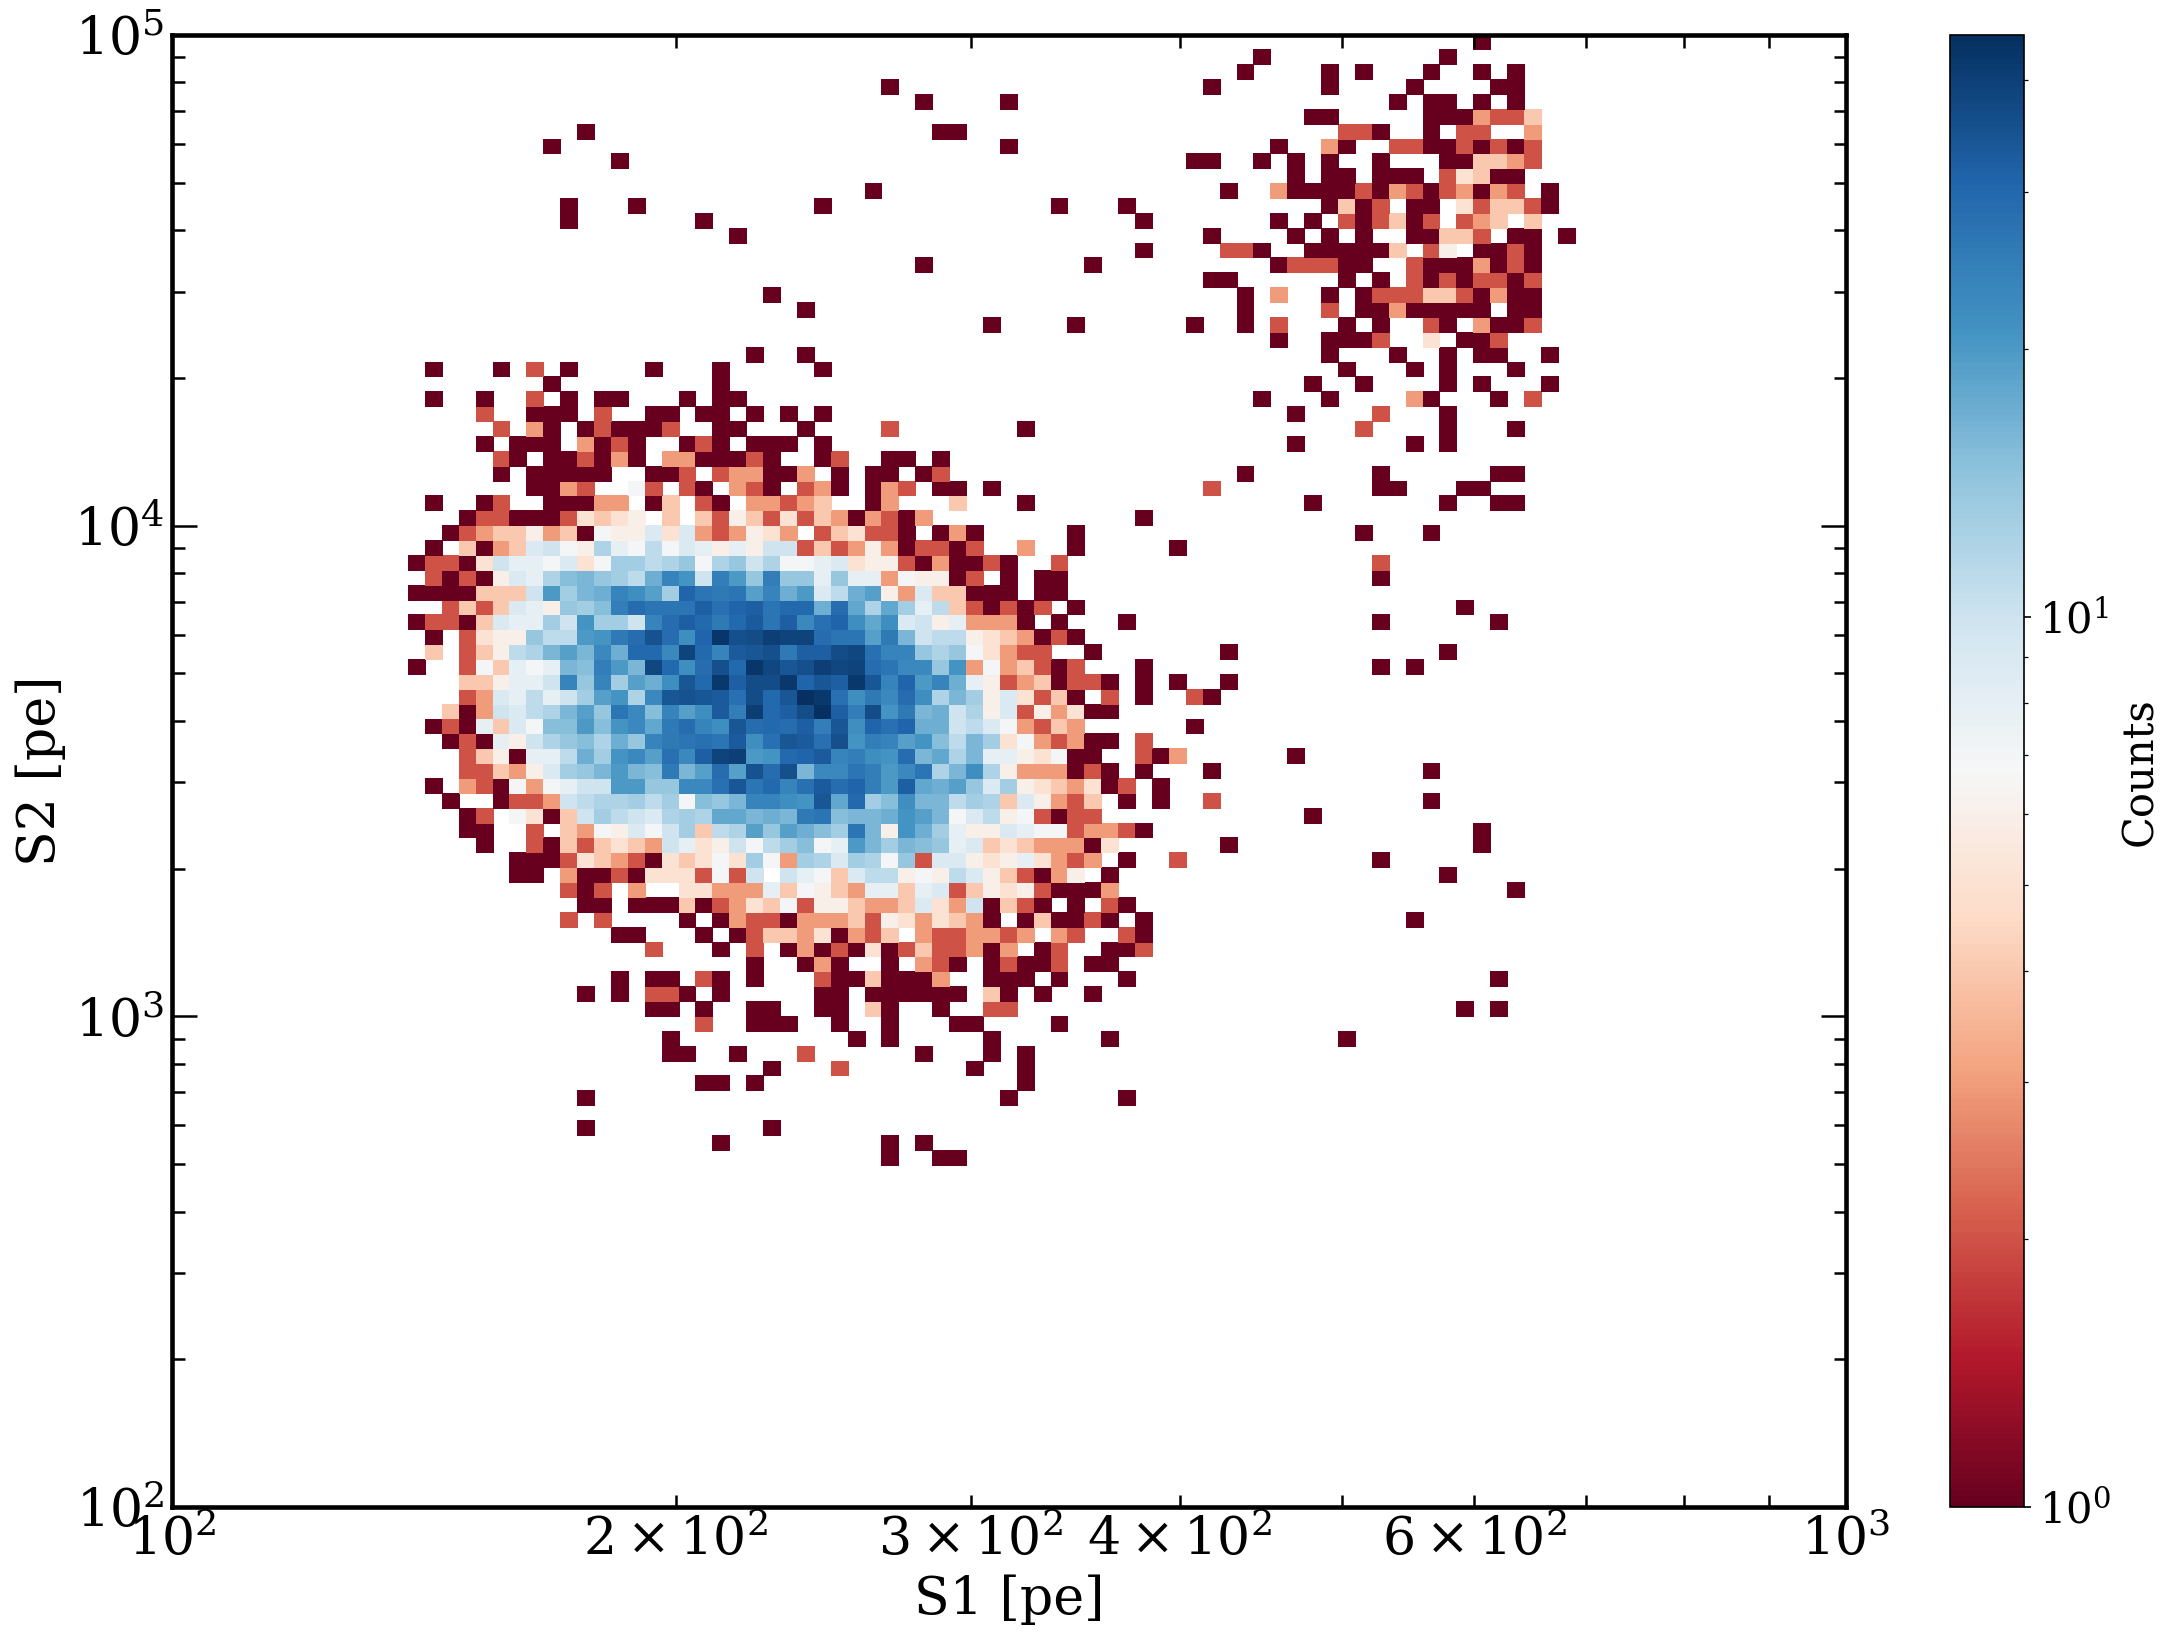

In [10]:
fig=plt.figure(figsize=(18, 13), dpi=150)

# Text options
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

# Labels
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# bins_x = np.linspace(100,400,100)
# bins_y = np.linspace(0,20000,100)

bins_x = np.logspace(2,3,100)
bins_y = np.logspace(2,5,100)
histo_max= 2*10**3



counts, _, _ = np.histogram2d(S1_area, S2_area, bins=(bins_x, bins_y))



im = axes.pcolormesh(bins_x, bins_y, counts.T, norm=mpl.colors.LogNorm(), cmap = 'RdBu')

cb = plt.colorbar(im, ax=axes, label='Counts/bin')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20) 
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('S1 [pe]')
axes.set_ylabel('S2 [pe]')


plt.show()


/software/anaconda3/envs/strax/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: covariance is not symmetric positive-semidefinite.


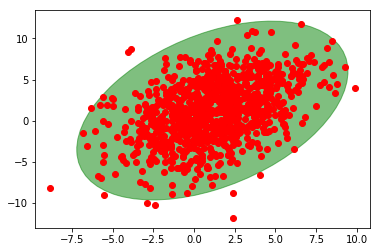

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

if __name__ == '__main__':
    #-- Example usage -----------------------
    # Generate some random, correlated data
    points = np.random.multivariate_normal(
            mean=(1,1), cov=[[0.4, 9],[9, 10]], size=1000
            )
    # Plot the raw points...
    x, y = points.T
    plt.plot(x, y, 'ro')

    # Plot a transparent 3 standard deviation covariance ellipse
    plot_point_cov(points, nstd=3, alpha=0.5, color='green')

    plt.show()